# Laboratorieøvelse 5
## Proteinfolding og kunstig intelligens

__Læringsmål:__
- Gjøre rede for faktorer som påvirker proteinfolding
- Bruke en enkel Monte Carlo-modell til å simulere proteinfolding
- Diskutere hvilke parametere og faktorer som påvirker simuleringen
- Reflektere over hvordan kunstig intelligens (f.eks. AlphaFold) kan anvendes til å forutsi proteinstruktur
- Bruke Pymol til å visualisere proteinstrukturer

### Hensikt
Hensikten med denne oppgaven er å gi en innføring i proteinfolding og hvordan kunstig intelligens kan brukes til å forutsi proteinstruktur. Vi skal bruke en enkel Monte Carlo-modell for å simulere proteinfolding og diskutere hvilke faktorer som påvirker foldingen. I tillegg vil vi se på hvordan kunstig intelligens kan anvendes i dette feltet, med fokus på AlphaFold. Gjennom laboppgaven skal du utforske hvordan vi kan bruke datamaskinen som et verktøy for å forstå interaksjoner mellom proteiner i virus, legemidler og antistoffer.

### Innledning
Proteinfolding er prosessen der et protein, ut fra sin aminosyresekvens, folder seg til en tredimensjonal struktur som er avgjørende for proteinets funksjon. Feilfolding kan føre til alvorlige sykdommer som Parkinsons og Alzheimers. I denne laboppgaven skal vi studere ulike faktorer som påvirker proteinfolding. Vi skal også se hvordan vi kan bruke kunstig intelligens (eller mer konkret, simuleringsalgoritmer) til å forutsi foldingen til ulike proteiner. Oppgavene tar utgangspunkt i en forenklet foldealgoritme. Denne modellen er selvsagt en grov forenkling av de komplekse kreftene som virker i virkeligheten, men gir et godt utgangspunkt for å diskutere hvilke faktorer som er viktige for proteinfolding.

I simuleringen nedenfor blir hvert "protein" representert som en kjede av "aminosyrer" der hver posisjon påvirkes av enkle regler og en energiberegning basert på blant annet gunstige interaksjoner.

Modellen vår tar for seg:

- Sekvensen: En streng med bokstaver (f.eks. "HPHPPH"), der H står for hydrofob og P for polar.
- Energifunksjon: En forenklet energifunksjon som bruker et Lennard-Jones-potensial for å regne ut hydrofobe interaksjoner mellom aminosyrene.
- Monte Carlo-metode: En simuleringsmetode der en tilfeldig valgt aminosyre flyttes til en ny posisjon med en viss sannsynlighet basert på visse kriterier.

Monte Carlo-metoder (MC-metoder) er stokastiske metoder der vi bruker tilfeldige tall for å modellere ulike systemer. I denne sammenhengen benyttes teknikken til å simulere proteinfolding ved å foreslå små, tilfeldige endringer i proteinets konformasjon og deretter evaluere disse endringene basert på et energikriterium. Ved å gjenta denne prosessen mange ganger, kan man velge ut gunstige strukturer ut av flere mulige strukturer, og dermed identifisere de konformasjonene som gir lavest energi. Dette gir en indikator på stabilitet. Denne metoden er nyttig i biologisk modellering fordi den gjør det mulig å studere systemer som ellers ville vært for komplekse å analysere deterministisk. 

Du trenger noen biblioteker i tillegg til standardbiblioteker som matplotlib og numpy for å kjøre koden. Installer dem med pip hvis du ikke har dem fra før:


In [ ]:
!pip install  ipympl, biopython

### Del 1: Monte-Carlo-simuleringer
Kjør koden nedenfor. Denne implementerer en enkel foldealgoritme med hydrofobe residuer (H) og hydrofile/polare residuer (P). Se animasjonen og beskriv hva du observerer:

- Observer foldingen. Hvordan endrer proteinets konformasjon seg over tid?
- Hvordan varierer energien under simuleringen? Legg merke til både den nåværende energien og den beste energien som oppnås underveis.
- Hvilken rolle spiller tilfeldige bevegelser i prosessen?
- Hvilke faktorer tar modellen hensyn til? 
- Hva mangler for å gjøre simuleringen mer realistisk?

Endre parameteren "sequence" systematisk og kjør simuleringen. Prøv ulike sekvenser: En med flere/bare hydrofobe (H) aminosyrer, en med flere/bare polare (P) aminosyrer, og blandede sekvenser.


- Diskuter hvordan aminosyresekvensen påvirker den endelige foldingen. Hvilke faktorer er viktige i denne modellen, og hvilke effekter er viktige i virkeligheten?
Hvordan påvirker antall H og P den endelige energien?
- Hvordan endrer konformasjonen seg? Får du et mer kompakt (foldet) protein med flere av den ene eller andre aminosyren? I så fall, hvorfor det?

__Tips:__ Det kan være lurt å bruke plot_best_configuration-funksjonen (som plottes til slutt) for å visualisere den beste konformasjonen for hver sekvens du tester.

Sett temperaturparameteren til for eksempel 310.15 (kroppstemperatur) og sammenlign med lavere temperaturer.

- Hvordan påvirker temperatur proteinets bevegelse og energi under folding?

In [48]:
import random
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
from matplotlib.animation import FuncAnimation

%matplotlib ipympl

### ENERGY FUNCTION (Continuous, Gaussian well) ###
def compute_energy_continuous(positions, sequence):
    """
    Computes the total energy of the conformation using a continuous Gaussian
    potential between every pair of non-adjacent H residues.

    For each pair (i,j) such that j>=i+2 and both residues are H:
      - If their Euclidean distance r is less than 'cutoff' (here 3.0), they 
        contribute an energy term: -exp(-((r-1)^2)/0.5).
      - This potential is minimum (–1) when r = 1 and decays smoothly as r deviates from 1.

    The resulting energy is a smooth, non-integer number.
    """
    energy = 0.0
    length = len(sequence)
    cutoff = 3.0  # only consider H–H pairs with r < cutoff
    for i in range(length):
        for j in range(i+2, length):
            if sequence[i] == 'H' and sequence[j] == 'H':
                dx = positions[i][0] - positions[j][0]
                dy = positions[i][1] - positions[j][1]
                dz = positions[i][2] - positions[j][2]
                r = math.sqrt(dx*dx + dy*dy + dz*dz)
                if r < cutoff:
                    # Gaussian potential: minimum of -1 at r=1, width parameter = 0.5.
                    energy += -math.exp(-((r-1)**2)/0.5)
    return energy

### INITIAL CONFIGURATION ###
def generate_initial_positions(sequence):
    """
    Generates an initial linear configuration for the chain in 3D.
    Each residue is placed consecutively along the x-axis.
    """
    positions = []
    for i in range(len(sequence)):
        positions.append((i, 0, 0))
    return positions

### BOUNDARY CHECKS ###
def is_within_boundaries(pos, boundaries):
    """
    Checks whether position pos (x,y,z) is within the specified boundaries.
    boundaries is a dictionary with keys 'x', 'y', and 'z'; each is a tuple (min, max).
    """
    x, y, z = pos
    return (boundaries['x'][0] <= x <= boundaries['x'][1] and
            boundaries['y'][0] <= y <= boundaries['y'][1] and
            boundaries['z'][0] <= z <= boundaries['z'][1])

def valid_move(positions, new_pos, index, boundaries):
    """
    Checks that the proposed new position for the residue at index:
      - lies within the boundaries, and
      - does not overlap any other residue.
    """
    if not is_within_boundaries(new_pos, boundaries):
        return False
    for i, pos in enumerate(positions):
        if i != index and pos == new_pos:
            return False
    return True

### MOVES: SINGLE-RESIDUE AND PIVOT ###
def apply_rotation(vec, matrix):
    """
    Rotates a 3D vector 'vec' using the provided 3x3 rotation matrix.
    """
    x, y, z = vec
    return (matrix[0][0]*x + matrix[0][1]*y + matrix[0][2]*z,
            matrix[1][0]*x + matrix[1][1]*y + matrix[1][2]*z,
            matrix[2][0]*x + matrix[2][1]*y + matrix[2][2]*z)

def attempt_pivot_move(positions, sequence, temperature, boundaries):
    """
    Attempts a pivot move:
      - Select a pivot (not an endpoint).
      - Choose a random rotation (90°, 180°, or 270° about one axis).
      - Rotate the chain segment beyond the pivot.
      - Reject the move if any residue goes outside the boundaries or if overlaps occur.
      - Accept/reject according to the Metropolis criterion.
    """
    length = len(positions)
    if length < 3:
        return positions, False
    pivot_index = random.randint(1, length - 2)
    pivot_point = positions[pivot_index]
    
    allowed_rotations = [
        [[1, 0, 0], [0, 0, -1], [0, 1, 0]],   # x-axis 90°
        [[1, 0, 0], [0, -1, 0], [0, 0, -1]],   # x-axis 180°
        [[1, 0, 0], [0, 0, 1], [0, -1, 0]],    # x-axis 270°
        [[0, 0, 1], [0, 1, 0], [-1, 0, 0]],     # y-axis 90°
        [[-1, 0, 0], [0, 1, 0], [0, 0, -1]],    # y-axis 180°
        [[0, 0, -1], [0, 1, 0], [1, 0, 0]],     # y-axis 270°
        [[0, -1, 0], [1, 0, 0], [0, 0, 1]],     # z-axis 90°
        [[-1, 0, 0], [0, -1, 0], [0, 0, 1]],    # z-axis 180°
        [[0, 1, 0], [-1, 0, 0], [0, 0, 1]]      # z-axis 270°
    ]
    rotation = random.choice(allowed_rotations)

    new_positions = positions.copy()
    # Rotate every residue beyond the pivot point
    for i in range(pivot_index+1, length):
        rel = (positions[i][0]-pivot_point[0],
               positions[i][1]-pivot_point[1],
               positions[i][2]-pivot_point[2])
        rotated_rel = apply_rotation(rel, rotation)
        new_positions[i] = (pivot_point[0] + rotated_rel[0],
                            pivot_point[1] + rotated_rel[1],
                            pivot_point[2] + rotated_rel[2])
    
    # Check for overlaps and boundary violations
    if len(set(new_positions)) < len(new_positions):
        return positions, False
    for pos in new_positions:
        if not is_within_boundaries(pos, boundaries):
            return positions, False

    old_energy = compute_energy_continuous(positions, sequence)
    new_energy = compute_energy_continuous(new_positions, sequence)
    delta_e = new_energy - old_energy

    if delta_e <= 0 or random.random() < math.exp(-delta_e / temperature):
        return new_positions, True
    else:
        return positions, False

def attempt_move(positions, sequence, temperature, pivot_probability, boundaries):
    """
    With probability pivot_probability attempt a pivot move; otherwise, attempt a
    single-residue move. Uses the continuous energy function.
    """
    if random.random() < pivot_probability:
        return attempt_pivot_move(positions, sequence, temperature, boundaries)
    else:
        length = len(sequence)
        index = random.randint(0, length - 1)
        old_pos = positions[index]
        moves = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]
        dx, dy, dz = random.choice(moves)
        new_pos = (old_pos[0] + dx, old_pos[1] + dy, old_pos[2] + dz)
        if not valid_move(positions, new_pos, index, boundaries):
            return positions, False
        old_energy = compute_energy_continuous(positions, sequence)
        positions_trial = positions.copy()
        positions_trial[index] = new_pos
        new_energy = compute_energy_continuous(positions_trial, sequence)
        delta_e = new_energy - old_energy
        if delta_e <= 0 or random.random() < math.exp(-delta_e / temperature):
            return positions_trial, True
        else:
            return positions, False

### SIMULATED ANNEALING SIMULATION ###
def run_simulation_annealing(sequence="HPPPHHHHHHHH", 
                             max_attempts=5000, 
                             initial_temperature=1.5,
                             final_temperature=0.2,
                             record_interval=10,
                             stop_threshold=1000,
                             pivot_probability=0.2,
                             boundaries=None):
    """
    Runs the Monte Carlo simulation with simulated annealing.
    The temperature decreases linearly from initial_temperature to final_temperature.
    
    Uses the continuous energy function (compute_energy_continuous) so that the energy
    is a smooth, non-integer quantity. Also, moves that place any residue outside the
    specified boundaries are rejected.
    """
    if boundaries is None:
        # Set boundaries so the chain remains visible.
        boundaries = {'x': (-10, len(sequence)+10),
                      'y': (-10, 10),
                      'z': (-10, 10)}
    
    positions = generate_initial_positions(sequence)
    energy = compute_energy_continuous(positions, sequence)
    energy_history = []
    positions_history = []
    best_energy = energy
    best_positions = positions.copy()
    consecutive_no_improvement = 0

    for step in range(max_attempts):
        # Use a gentle, linear cooling schedule.
        temperature = initial_temperature + (final_temperature - initial_temperature) * (step / max_attempts)
        positions, accepted = attempt_move(positions, sequence, temperature, pivot_probability, boundaries)
        new_energy = compute_energy_continuous(positions, sequence)
        
        if new_energy < best_energy:
            best_energy = new_energy
            best_positions = positions.copy()
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1
        
        if step % record_interval == 0:
            energy_history.append(new_energy)
            positions_history.append(positions.copy())
        
        if consecutive_no_improvement >= stop_threshold:
            energy_history.append(new_energy)
            positions_history.append(positions.copy())
            print(f"Stopped early at step {step} with energy {new_energy}")
            break
    else:
        energy_history.append(new_energy)
        positions_history.append(positions.copy())

    return best_positions, best_energy, positions_history, energy_history

### ANIMATION ###
def animate_folding(sequence="HPPPHHHHHHHH", 
                    max_attempts=5000, 
                    initial_temperature=1.5,
                    final_temperature=0.2,
                    record_interval=10,
                    stop_threshold=1000,
                    pivot_probability=0.2,
                    boundaries=None):
    """
    Runs the annealing simulation and creates an animation of the folding process.
    """
    best_positions, best_energy, positions_history, energy_history = run_simulation_annealing(
        sequence=sequence,
        max_attempts=max_attempts,
        initial_temperature=initial_temperature,
        final_temperature=final_temperature,
        record_interval=record_interval,
        stop_threshold=stop_threshold,
        pivot_probability=pivot_probability,
        boundaries=boundaries
    )

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    color_map = {'H': 'red', 'P': 'blue'}

    def update(frame):
        ax.clear()
        current_positions = positions_history[frame]
        x_data = [p[0] for p in current_positions]
        y_data = [p[1] for p in current_positions]
        z_data = [p[2] for p in current_positions]
        colors = [color_map.get(res, 'black') for res in sequence]
        ax.scatter(x_data, y_data, z_data, c=colors, s=80)
        for i in range(len(current_positions) - 1):
            xline = [current_positions[i][0], current_positions[i+1][0]]
            yline = [current_positions[i][1], current_positions[i+1][1]]
            zline = [current_positions[i][2], current_positions[i+1][2]]
            ax.plot(xline, yline, zline, color='gray', linewidth=2)
        ax.set_xlim(boundaries['x'])
        ax.set_ylim(boundaries['y'])
        ax.set_zlim(boundaries['z'])
        best_so_far = min(energy_history[:frame+1])
        ax.set_title(f"Step: {frame*record_interval}\nCurrent Energy: {energy_history[frame]:.3f}\nBest Energy: {best_so_far:.3f}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
    
    anim = FuncAnimation(fig, update, frames=len(positions_history), interval=300, blit=False, repeat=False)
    print(f"Best energy reached: {best_energy:.3f}")
    return anim, best_positions, best_energy

### PLOT BEST CONFIGURATION ###
def plot_best_configuration(best_positions, best_energy, sequence):
    """
    Plots the best (lowest-energy) configuration achieved during the simulation.
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    color_map = {'H': 'red', 'P': 'blue'}
    x_data = [p[0] for p in best_positions]
    y_data = [p[1] for p in best_positions]
    z_data = [p[2] for p in best_positions]
    colors = [color_map.get(res, 'black') for res in sequence]
    ax.scatter(x_data, y_data, z_data, c=colors, s=80)
    for i in range(len(best_positions) - 1):
        xline = [best_positions[i][0], best_positions[i+1][0]]
        yline = [best_positions[i][1], best_positions[i+1][1]]
        zline = [best_positions[i][2], best_positions[i+1][2]]
        ax.plot(xline, yline, zline, color='gray', linewidth=2)
    ax.set_xlim((-10, len(sequence)+10))
    ax.set_ylim((-10, 10))
    ax.set_zlim((-10, 10))
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"Best Configuration\nEnergy: {best_energy:.3f}")
    plt.show()

Stopped early at step 1019 with energy 0.0
Best energy reached: -1.672


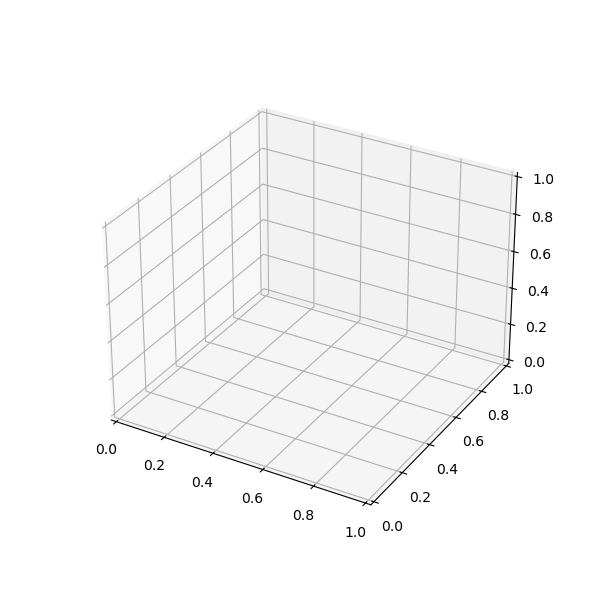

In [49]:
sequence = "HPPPHHHHPPHHHH"
boundaries = {'x': (-10, len(sequence)+10),
                'y': (-10, 10),
                'z': (-10, 10)}

anim, best_positions, best_energy = animate_folding(
    sequence=sequence,
    max_attempts=5000,
    initial_temperature=273.15,
    final_temperature=0.2,
    record_interval=10,
    stop_threshold=1000,
    pivot_probability=0.2,
    boundaries=boundaries
)

# In Jupyter Notebook, to display the animation interactively:
# from IPython.display import HTML
# HTML(anim.to_jshtml())
plt.show()

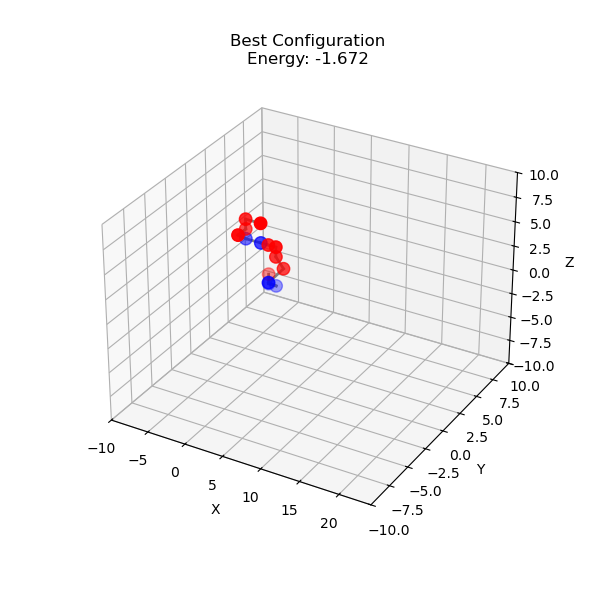

In [50]:
# Now plot the best configuration using the returned variables
plot_best_configuration(best_positions, best_energy, sequence)

### Del 2: Proteinfolding med kunstig intelligens
Simuleringen ovenfor illustrerer proteinfolding ved hjelp av en sterkt forenklet modell. Å modellere folding av store proteiner er langt mer utfordrende, blant annet fordi det krever presis beskrivelse av en rekke ikke-kovalente interaksjoner – som hydrogenbindinger, hydrofobe effekter, van der Waals-krefter og elektrostatiske interaksjoner – samt en vurdering av hvilke som dominerer i ulike kontekster. Selve foldingen skjer gjennom en sekvens av konformasjonsendringer, hvor tidligere strukturelle valg begrenser de påfølgende mulighetene. Denne prosessen beskrives ofte som en bevegelse gjennom et komplekst konformasjons- eller energilandskap. Til tross for betydelige fremskritt, er mekanismene bak hvordan proteiner finner sin biologisk aktive struktur fortsatt et aktivt forskningsfelt.

Kunstig intelligens (AI) har revolusjonert feltet proteinfolding, spesielt med utviklingen av AlphaFold, som bruker dype læringsmetoder for å forutsi proteinstrukturer med høy nøyaktighet. AlphaFold er trent på store datasett av kjente proteinstrukturer og deres sekvenser, og bruker denne informasjonen til å lage prediksjoner om hvordan nye proteiner vil folde seg. Dette har ført til betydelige fremskritt innen biomedisinsk forskning, legemiddelutvikling og forståelse av sykdomsmekanismer.

AlphaFold er en AI-modell utviklet av DeepMind som har gjort betydelige fremskritt innen proteinfolding. Den bruker dype nevrale nettverk for å forutsi proteinstrukturer basert på aminosyresekvenser. AlphaFold er i stand til å forutsi proteinstrukturer med høy nøyaktighet, selv for store og komplekse proteiner. Dette er en betydelig forbedring sammenlignet med tidligere metoder, som ofte var tidkrevende og krevde mye eksperimentering. AlphaFold bruker en kombinasjon av dype nevrale nettverk og fysikkbaserte modeller for å lage prediksjoner om proteinfolding. Dette gjør det mulig å forutsi strukturer på en raskere og mer effektiv måte enn tidligere metoder.

AlphaFold har blitt brukt til å forutsi strukturer av mange kjente proteiner, og har også vært nyttig i legemiddelutvikling og forståelse av sykdomsmekanismer. Det er imidlertid viktig å merke seg at AlphaFold ikke er en perfekt løsning, og det er fortsatt utfordringer knyttet til å forutsi strukturer av store og komplekse proteiner. I tillegg er det fortsatt behov for eksperimentelle metoder for å validere prediksjonene gjort av AlphaFold.


- Diskuter hva som er hovedutfordringene med fysiske simuleringer av proteinfolding.
- Hvordan kan metoder basert på kunstig intelligens, slik som AlphaFold, hjelpe til med å løse disse utfordringene?
- Hvilke aspekter ved proteinfolding tror du AI-modeller klarer å fange bedre enn den enkle modellen vi har brukt?

##### Oppgave A: Influensavirus og legemiddelutvikling
Influensaviruset har to glykoproteiner på overflaten: hemagglutinin og neuraminidase. Hemagglutinin er ansvarlig for binding til sialinsyrereseptorer og initiering av infeksjon, mens neuraminidase kløyver av sialinsyre og gjør at viruset kan spre seg videre i kroppen. 

Vi skal bruke AlphaFold til å forutsi strukturen til neuraminidase, et protein som er viktig for influensavirusets evne til å infisere celler. Neuraminidase er et enzym som bryter ned sialinsyre, en sukkerart som finnes på overflaten av celler. Dette enzymet er avgjørende for virusets evne til å spre seg i vertscellen. Studiet av neuraminidase er viktig for forståelsen av influensavirusets biologi og utviklingen av antivirale legemidler. Neuraminidase er også et mål for vaksiner mot influensa, og forståelsen av proteinets struktur og funksjon kan bidra til utviklingen av mer effektive vaksiner.

Du skal bruke Pymol til å visualisere molekylene i denne oppgaven, og du skal bruke alphafoldserver.com til å gjøre strukturprediksjone AlphaFold. Siden AlphaFold tar utgangspunkt i aminosyresekvensen, skal vi bruke FASTA-formatet for å representere sekvensen. FASTA er en vanlig måte å representere biologiske sekvenser på, og det brukes ofte i bioinformatikk for å lagre og dele sekvenser av DNA, RNA og proteiner. En FASTA-fil inneholder en eller flere sekvenser, hver med en beskrivelse som begynner med et ">"-tegn etterfulgt av en identifikator og eventuelt annen informasjon. Sekvensen følger deretter på neste linje med enbokstavekodene som representerer aminosyrene i proteinet.

Kopier FASTA-sekvensen for neuraminidase: https://www.rcsb.org/fasta/entry/2HT8/display. Merk deg hvordan du finner FASTA-sekvensen fra PDB-strukturen. Du kan bruke RCSB PDB-nettstedet til å søke etter strukturen og deretter laste ned sekvensen i FASTA-format.

Gå til alphafoldserver.com og lim inn FASTA-sekvensen. Trykk på "Continue and preview job" og deretter "Confirm and submit". Vent til jobben er fullført. 
Last deretter ned prediksjonsdataene. Det inneholder flere modeller som Alphafold har prediktert, og data om prediksjonen (i .json-format). Vi er her interesserte i strukturfilene (i .cif-format). Åpne den første modellen (modell 0) i Pymol og gi den det nye navnet "prediksjon". Vi skal sammenligne denne med den eksperimentelt bestemte strukturen (PDB 2HT8). Last ned PDB-filen fra RCSB PDB-nettstedet og åpne den også i Pymol. Gi dem ulike navn i Pymol, slik at du kan skille dem fra hverandre.

Vi ønsker kun å sammenligne de to strukturene i proteinet, uten alle tilleggsmolekyler. For å gjøre dette, må vi velge ut de atomene vi er interessert i. I dette tilfellet ønsker vi å sammenligne alfa-karbonatomene (CA) i de to strukturene. Dette kan gjøres ved å bruke seleksjonsverktøyet i Pymol:

```{code-block}raw
align 2ht8 and polymer and name CA, prediksjon and polymer and name CA, object=alnObj, cycles=5, transform=1
```

Her betyr "name CA" at du kun velger atomer med navnet "CA" (alfa-karbonatomer). Alfa-karbonatomene er standarden når vi skal beregne gjennomsnittlig avstand mellom prediksjon og eksperimentelle data, siden de finnes i alle aminosyrer og gir et konsistent mål på strukturell likhet. 

Selve kommandoen "align" brukes til å sammenligne og overlappe to strukturer basert på posisjonene til alfa-karbonatomene. I dette tilfellet sammenlignes strukturen med PDB-ID 2ht8 (eksperimentell struktur) med prediksjon (en modellert eller beregnet struktur). Begge begrenses til kun å inkludere polymerkjeder og alfa-karbonatomer. Argumentet object=alnObj angir at resultatet av justeringen skal lagres i et nytt PyMOL-objekt kalt alnObj, slik at man visuelt kan se overlappet etterpå. Videre sier cycles=5 at PyMOL skal gjøre fem iterasjoner med superposisjonering og utvalg av samsvarende atomer for å optimalisere justeringen. Til slutt betyr transform=1 at prediksjon-strukturen faktisk blir flyttet (transformert) slik at den best overlapper med 2ht8. Hvis transform=0, ville ingen strukturer blitt flyttet, og vi ville kun fått RMSD-verdien (avstanden mellom strukturene) uten visuell justering.


Når du bruker align-funksjonen i Pymol, får du automatisk en beregning av RMSD (Root Mean Square Deviation). Noter denne verdien. Dette er et mål på den gjennomsnittlige avstanden mellom tilsvarende atomer i to overlappende strukturene. RMSD blir beregnet som kvadratroten av gjennomsnittet av de kvadrerte avstandene mellom hvert par tilsvarende atomer:

$$
\text{RMSD} = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left\| \mathbf{x}_i - \mathbf{y}_i \right\|^2 }
$$

Her er $N$ antall atomer (for eksempel Cα-atomer), og $\mathbf{x}_i$ og $\mathbf{y}_i$ er posisjonsvektorene til det $i$-te atomet i henholdsvis den eksperimentelle strukturen og modellen. Dobbeltstrekene $\left\| \cdot \right\|$ markerer euklidisk norm, altså vanlig avstand i rommet mellom to punkter.

Normen $\left\| \mathbf{x}_i - \mathbf{y}_i \right\|$ er avstanden mellom to punkter i rommet, og kan skrives som:

$$
\left\| \mathbf{x}_i - \mathbf{y}_i \right\| = \sqrt{(x_{ix} - y_{ix})^2 + (x_{iy} - y_{iy})^2 + (x_{iz} - y_{iz})^2}
$$

hvor $x_{ix}, x_{iy}, x_{iz}$ er x-, y- og z-koordinatene til det $i$-te atomet i den ene strukturen, og $y_{ix}, y_{iy}, y_{iz}$ er koordinatene til det tilsvarende atomet i den andre strukturen. Vi regner først ut forskjellen i hver retning, kvadrerer dem, summerer, og tar kvadratroten.

RMSD-verdien uttrykker hvor godt to strukturer overlapper etter superposisjon – jo lavere verdi, desto mer lik er den modellerte strukturen den eksperimentelle.

- Hva er RMSD-verdien for neuraminidase? Hvordan tolker du denne verdien?
- Hvordan kan du bruke RMSD til å vurdere kvaliteten på en proteinmodell?

#### Oppgave B: Influensamedisin
Når har vi sett hvordan vi kan forutsi strukturer med kunstig intelligens og hvordan vi kan validere dette med eksperimentelle data. Vi kan selvsagt også bruke de samme modellene for å forutsi strukturen på proteiner vi ikke kjenner strukturen til, eller undersøke hvordan små endringer i sekvensen – som en mutasjon i én enkelt aminosyre – kan påvirke den tredimensjonale formen. Dette gir oss et kraftig verktøy for å utforske sammenhengen mellom proteinets primærstruktur og dets funksjon, og for å forstå hvordan mutasjoner kan føre til tap av funksjon, sykdom eller endret legemiddelrespons.

Vi skal nå se hvordan en enkelt mutasjon i influensavirusets overflateprotein gjør at legemiddelet Tamiflu ikke lenger binder seg effektivt. Ved hjelp av AlphaFold kan vi sammenligne den muterte strukturen med den opprinnelige, og analysere hvordan bindingslommen endres som følge av mutasjonen.

Neruaminidase binder seg som nevnt til sialinsyre i kroppen vår, som er en type sukker som finnes på celleoverflater i kroppen vår, blant annet som en del av glykoproteiner og glykolipider. Sialinsyre bidrar til å gi cellene en negativ ladning og spiller en viktig rolle i cellecellekommunikasjon/signalering og immunsystemfunksjoner. Neuraminidase kløyver sialinsyre fra disse strukturene, noe som hjelper viruset å unngå immunsystemet og spre seg effektivt.

Strukturen til sialinsyre er vist nedenfor. I Pymol-strukturen som du har lastet ned, finnes istedenfor _oseltamivir_ (ofte under merkenavnet "Tamiflu"), som er et legemiddel som hemmer enzymet slik at det ikke kan kløyve sialinsyre. Vis den i Pymol og se hvordan den binder seg til neuraminidase, gjerne ved å visualisere alle residuer som befinner seg innen 4 Å fra sialinsyre.

- Hva betyr det at oseltamivir er en substratanalog?
- Hvilke typer interaksjoner er det mellom oseltamivir og enzymet?
- Kan du forklare hvorfor oselatiminivir binder bedre enn sialinsyre? 

In [51]:
import py3Dmol

sialinsyre = py3Dmol.view(query='cid:129878003')
sialinsyre.setStyle({"stick": {"color":"spectrum"}})
#sialinsyre.zoomTo()
sialinsyre.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

##### Mutasjoner
Virus og andre patogener muterer og tilpasser seg miljøet, noe som kan gjøre dem resistente overfor naturlig forsvar eller legemidler. Vi skal nå se på hva som skjer med bindingen av legemidlet oseltamivir til neuraminidase dersom vi får en mutasjon i influensaviruset.

Nedenfor finner du Python-funksjoner som henter aminosyresekvensen til et protein fra en PDB-fil og endrer en spesifikk aminosyre til en annen. Du kan bruke disse funksjonene til å lage en ny sekvens med en mutasjon i neuraminidase-strukturen. Kjør funksjonene. De returnerer en FASTA-sekvens som du kan bruke videre i AlphaFold.

In [ ]:
from Bio.PDB import PDBParser

trebokstav_til_enbokstav = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E',
    'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N',
    'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S',
    'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

def hent_modellert_sekvens_og_kobling(pdb_fil, kjede_id):
    parser = PDBParser(QUIET=True)
    struktur = parser.get_structure("protein", pdb_fil)
    kjede = struktur[0][kjede_id]

    sekvens = ""
    kobling = []  # (FASTA_indeks, PDB_posisjon, aa)

    for resid in kjede:
        if resid.id[0] == " ":
            atomer = [atom.get_id() for atom in resid]
            if all(atom in atomer for atom in ("N", "CA", "C")):  # modellerte residuer
                aa = trebokstav_til_enbokstav.get(resid.get_resname(), "X")
                if aa != "X":
                    sekvens += aa
                    posisjon = resid.id[1]
                    kobling.append((len(sekvens), posisjon, aa))  # 1-basert indeks

    return sekvens, kobling

def skriv_fasta(sekvens, filnavn, header):
    with open(filnavn, "w") as f:
        f.write(header + "\n")
        f.write(sekvens + "\n")


Nå skal vi bruke funksjonene til å lage en ny sekvens med en mutasjon i neuraminidase-strukturen. Finn pdb-fila "2ht8.pdb" på RCSB PDB-nettstedet og last den ned. Vi velger igjen å bare se på alfa-kjeden (A) i proteinet. Muter aminosyren Arg292 til Lys292. Du får da en ny sekvens lagret i FASTA-format som du kan bruke i AlphaFold. Denne finner du i samme mappe som programmet/notebooken din.

In [ ]:
pdb_fil = "2ht8.pdb"
kjede_id = "A"
sekvens, kobling = hent_modellert_sekvens_og_kobling(pdb_fil, kjede_id)

# Finn hvilken FASTA-indeks som tilsvarer PDB-posisjon 292
for fasta_indeks, pdb_pos, aa in kobling:
    if pdb_pos == 292:
        print(f"PDB-posisjon 292 finnes på FASTA-indeks {fasta_indeks} og er {aa}")

# Muter aminosyre ved riktig FASTA-indeks (f.eks. til K)
fasta_indeks_292 = [f for f, p, a in kobling if p == 292][0] - 1
mutert = sekvens[:fasta_indeks_292] + "K" + sekvens[fasta_indeks_292+1:]

skriv_fasta(mutert, "mutert.fasta", ">mutert_protein | R292K")


PDB-posisjon 292 finnes på FASTA-indeks 211 og er R


Bruk FASTA-fila til det muterte proteinet i AlphaFold og sammenlign med den opprinnelige strukturen ved å bruke Pymol på samme måte som beskrevet tidligere.
- Hvordan endrer den muterte strukturen seg i forhold til den opprinnelige?
- Hvorfor tror du at denne mutasjonen fører til redusert binding av legemiddelet?
- Hvordan kan dette påvirke virusets evne til å spre seg i kroppen?
- Hvordan kan dette påvirke utviklingen av antivirale legemidler?


#### Oppgave C: Kroppens naturlige forsvar

Kroppens immunforsvar produserer antistoffer som gjenkjenner bestemte strukturer, for eksempel hemagglutinin på overflaten av influensavirus. For å unngå å bli oppdaget og nøytralisert, kan viruset endre deler av overflateproteinet sitt slik at antistoffene binder seg dårligere.

Antistoffet 2D1 (PDB ID: 3LZF) er i stand til å feste seg både til hemagglutininvarianten som fantes hos spanskesykeviruset i 1918, og til svineinfluensaviruset som sirkulerte i 2009. Nå skal vi undersøke hvordan en enkelt aminosyresubstitusjon kan påvirke denne bindingen. I følgende sekvens er aminosyren lysin (L, Lys) i posisjon 166 erstattet med glutamat (E, Glu):

ADPGDTICIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDSHNGKLCKLKGIAPLQLGKCNIAGWLLGNPECDLLLTA \
SSWSYIVETSNSENGTCYPGDFIDYEELREQLSSVSSFEKFEIFPKTSSWPNHETTKGVTAACSYAGASSFYRNLLWL \
TKKGSSYPKLS **E** SYVNNKGKEVLVLWGVHHPPTGTDQQSLYQNADAYVSVGSSKYNRRFTPEIAARPKVRDQAGR \
MNYYWTLLEPGDTITFEATGNLIAPWYAFALNRGSGSGIITSDAPVHDCNTKCQTPHGAINSSLPFQNIHPVTIGECP \
KYVRSTKLRMATGLRNIPSIQSR

- Formuler en hypotese om hvordan denne mutasjonen kan påvirke bindingen av antistoffet til hemagglutinin.
- Gjør nødvendige analyser for å forutsi hvordan denne mutasjonen påvirker bindingen av antistoffet til hemagglutinin. Bruk det du har lært tidligere i laboppgaven.
- Vurder hvordan denne mutasjonen kan påvirke virusets evne til å unngå immunresponsen ut fra de resultatene du får.

#### Oppgave D: Ukjente proteiner
Når vi lager nye proteiner eller undersøker et protein vi ikke kjenner fra før, kan vi ikke beregne RMSD eller tilsvarende for å validere modellen vi får fra AlphaFold. I stedet bruker vi ofte såkalte "tillitsområder" (confidence regions) for å vurdere hvor sikre vi er på at modellen er korrekt. Dette er områder i proteinet der AlphaFold har høy tillit til at strukturen er riktig, og områder der den har lav tillit.

En vanlig måte å validere usikkerhet på, er å bruke pLDDT (Predicted Local Distance Difference Test). AlphaFold gir oss en pLDDT-score for hver aminosyre – et mål på hvor sikker modellen er på plasseringen av denne residuen. pLDDT  er en verdi mellom 0 og 100:

- Over 90: Høy konfidens – strukturen er sannsynligvis korrekt.
- 70–90: God konfidens – brukbar modell.
- 50–70: Lav konfidens – modellen er usikker.
- Under 50: Svært lav konfidens – regionen kan være ustrukturert.

pLDDT er altså et mål AlphaFold bruker for å uttrykke hvor sikker modellen er på plasseringen av hver enkelt aminosyre i den tredimensjonale strukturen. Modellen estimerer pLDDT ved at den lærer statistisk hvilke typer aminosyrer, posisjoner, kontaktmønstre og evolusjonære homologer som gir stabil struktur. Den bruker disse mønstrene til å forutsi hvor mye avstandene mellom residuer sannsynligvis vil variere, hvis man hadde hatt mange eksperimentelle eller predikerte strukturer. Jo mindre forventet variasjon, desto høyere pLDDT. pLDDT er altså et mål på **geometrisk troverdighet** i modellen. Det er viktig å merke seg at pLDDT-verdier gir en indikasjon på  modellens nøyaktighet, men er ikke et mål på om modellen er _riktig_.

Ta utgangspunkt i følgende aminsoyresekvens og last opp til AlphaFold:

```{code-block}raw
ADPGDTICHANNYVLNDGGPTDTVDTVLEKNVTVTHSVNLLEDSHNGKLCKLKGIAPLQLGKCNIAGWLLGNPECDLLLTASSWSYIVETSNSENGTCYPGDFIDYEELREQLSSVSSFEKFEIFPKTSSWPNHETTKGVTAACSYAGASSFYRNLLWLTKKGSSYPKLSESYVNNKGKEVLVLWGVHHPPTGTDQQSLYQNADAYVSVGSSKAIEPPGDTIWYRRNGSIITLLEPGDTITFEATGNLIAPWYAFALNRGSGSGIITSDAPVHDCNTKCQTPHGAINSSLPFQNIHPVTIGECPKYVRSTKLRMATGLRNIPSIQSR
```

AlphaFold har innebygde metoder for å estimere og visualisere usikkerhet i prediksjonen, men vi skal bruke PyMOL til å gjøre dette. Last ned CIF-filen med prediksjonen og åpne den i PyMOL. Du kan bruke følgende kommandoer for å laste opp CIF-filen du får fra AlphaFold:

```{code-block}pymol
load alphafold_model.cif 
```

For å visualisere pLDDT-verdiene, kan du bruke følgende kommandoer i PyMOL:

```{code-block}pymol 
spectrum b, blue_white_red, minimum=0, maximum=100
show cartoon
bg_color white
set ray_opaque_background, off
````

Nå kan du se hvordan pLDDT-verdiene er fordelt i strukturen. Du kan også bruke følgende kommandoer for å lage to utvalg av områder med høy og lav tillit:

```{code-block}pymol
select lav_tillit, b < 50
select hoy_tillit, b > 90
```

Bruk gjerne ulike representasjoner for å visualisere de ulike områdene. Du kan for eksempel bruke staver for lavtillitsområder og tegne dem i rødt, mens du kan bruke en mer detaljert representasjon (f.eks. "cartoon") for høy tillit og tegne dem i blått:

```{code-block}pymol
show sticks, lav_tillit
color red, lav_tillit

show cartoon, hoy_tillit
color blue, hoy_tillit
```

Vi kan også visualisere hele proteinet med en overflate for å se hvordan det ser ut i sin helhet. Dette kan gjøres med følgende kommandoer:

```{code-block}pymol
show surface
set transparency, 0.5
```

- Hvorfor kan vi ikke bruke RMSD for å validere modeller vi ikke kjenner strukturen til fra før?
- Hva er pLDDT, og hvordan kan det brukes til å vurdere kvaliteten på en proteinmodell?
- Hvor i proteinet finner du lavtillitsområder? Hvordan passer dette med det du vet om fleksibilitet og struktur i proteiner?
- På hvilke områder av proteinet er det viktigst å ha høy tillit? 

### Oppsummering
- Hva er de viktigste faktorene som påvirker proteinfolding?
- Hva er begreningene ved fysiske simuleringer av proteinfolding?
- Hvordan kan kunstig intelligens brukes til å forutsi proteinstrukturer?
- Hvordan kan vi bruke simuleringer til å forstå proteinfolding og legemiddelutvikling?
- Du har arbeidet med å bruke og evaluere modeller for proteinfolding. Hvordan kan vi bruke modeller for å forstå biokjemiske prosesser? Hvordan jobber vi med modeller i kjemi? Har du eksempler fra andre deler av kjemi der vi bruker modeller på samme måte?